# Stress Test : Analyse de risque de crédit – Portefeuille Alpha

## <span style="color:#1f4fd8;">1. Introduction</span>

Ce projet s’inscrit dans une logique de **Risk Management / Data Science bancaire**, appliqué à la **Banque Alpha**, dans un contexte macroéconomique dégradé (**Stagflation Sévère 2026**).

L’objectif est de réaliser un **stress test global de portefeuille** pour :
- analyser la **sensibilité du portefeuille** aux chocs macroéconomiques,
- comparer deux secteurs stratégiques (Cyclic : **Construction**, Défensif : **Grande Distribution**),
- mesurer l’impact du stress sur la **Probabilité de Défaut (PD)** et la **Perte Attendue (EL)**.

Deux sous-portefeuilles sont simulés à partir d’un portefeuille global de 130 entreprises, réparties de manière probabiliste entre deux secteurs stratégiques :

- **Construction** (secteur cyclique, plus sensible aux chocs macroéconomiques),
- **Grande Distribution** (secteur défensif, plus résilient).

La répartition sectorielle est générée de façon aléatoire selon des probabilités réalistes, garantissant une structure de portefeuille crédible et représentative.


---

## <span style="color:#1f4fd8;">2. Méthodologie</span>

L’analyse repose sur une approche structurée de stress testing de portefeuille de crédit, inspirée des pratiques utilisées en gestion du risque bancaire. La méthodologie suivie se décompose en plusieurs étapes successives.

### 2.1 Construction du portefeuille de référence
Un portefeuille de crédit initial est constitué à partir de données simulées mais réalistes, intégrant :
- une répartition sectorielle (Construction, Grande Distribution),
- des encours cohérents avec l’activité des contreparties,
- des notations de crédit,
- des paramètres de risque (PD, LGD).

Ce portefeuille sert de base à l’ensemble des analyses.

### 2.2 Calcul de la perte attendue en situation normale
La perte attendue (Expected Loss – EL) est calculée pour chaque exposition selon la formule standard :

\[
EL = PD \times LGD \times Encours
\]

Cette étape permet d’évaluer le niveau de risque moyen du portefeuille en situation non stressée.

### 2.3 Analyses descriptives et sectorielles
Des analyses statistiques et graphiques sont menées afin d’identifier :
- la distribution des pertes attendues par secteur,
- les concentrations potentielles de risque,
- la cohérence entre notation, exposition et perte attendue.

### 2.4 Extension du portefeuille par simulation
Le portefeuille est élargi via une simulation de données supplémentaires afin de :
- renforcer la représentativité statistique,
- reproduire une structure de portefeuille plus proche d’un cas réel,
- analyser les comportements de risque à plus grande échelle.

À partir du portefeuille initial, une extension est réalisé par simulation afin de générer un portefeuille plus représentatif d’un cas réel.
Le portefeuille est ainsi élargi à 130 entreprises, réparties de manière probabiliste entre les secteurs cyclique et défensif, avec des paramètres de risque cohérents (PD, LGD, encours).
Cette étape permet d’analyser les comportements de risque à une échelle plus réaliste et d’améliorer la robustesse du stress test.

### 2.5 Application d’un scénario de stress sévère
Un scénario de stress macroéconomique est appliqué, reposant sur une augmentation significative des probabilités de défaut, particulièrement sur le secteur de la Construction. Les pertes attendues sont recalculées après stress afin de mesurer l’impact du choc.

### 2.6 Comparaison avant / après stress
Les résultats obtenus en situation normale et en situation stressée sont comparés afin d’évaluer :
- la sensibilité du portefeuille aux chocs extrêmes,
- la contribution sectorielle au risque global,
- la robustesse du portefeuille.

### 2.7 Visualisation, interrogation et interprétation des résultats
Les résultats sont synthétisés à l’aide de graphiques, de tableaux analytiques et de requêtes SQL, facilitant l’interprétation économique et financière des impacts observés.
En complément des analyses réalisées sous Python, certaines agrégations (par secteur, par notation, par niveau de risque) sont reproduites via des requêtes SQL afin d’illustrer une approche analytique relationnelle classique en environnement bancaire.



---

## <span style="color:#1f4fd8;"> 3. Import des bibliothèques</span>


*Stress Test – Global Credit Risk*  
*Auteur : Carole*  
*Reproductibilité : `np.random.seed(42)`*


### 3.1 Environnement technique et reproductibilité

L’analyse est réalisée sous JupyterLab via Anaconda.  
Les versions exactes des bibliothèques sont affichées afin de garantir
la reproductibilité des résultats.


In [1]:
import sys
import numpy as np
import pandas as pd

print("Python :", sys.version)
print("NumPy :", np.__version__)
print("Pandas :", pd.__version__)


Python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
NumPy : 1.26.4
Pandas : 2.2.2


### 3.2 Import des bibliothèques d’analyse

Les bibliothèques utilisées couvrent :
- le calcul numérique (NumPy),
- la manipulation de données (Pandas),
- la visualisation (Matplotlib, Seaborn).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 3.3 Préparation de l’environnement de données

Un dossier de travail est créé afin de stocker les jeux de données
et résultats intermédiaires de l’analyse.


In [3]:
import os

# Création du dossier 'data' s'il n'existe pas déjà
os.makedirs("data", exist_ok=True)


### 3.4 Création du jeu de données initial

Un portefeuille de référence est construit afin de servir de base à l’analyse de risque et aux scénarios de stress.


In [4]:
# Exemple de données du portefeuille
data = {
    'Secteur': ['Construction', 'Grande Distribution', 'Construction', 'Grande Distribution'],
    'Encours': [1500000, 2000000, 1200000, 1800000],
    'PD': [0.02, 0.01, 0.025, 0.015],
    'LGD': [0.45, 0.4, 0.5, 0.35]
}

# Création du DataFrame
df = pd.DataFrame(data)




### 3.5 Sauvegarde du jeu de données

Le jeu de données est sauvegardé afin de permettre une réutilisation et une traçabilité des analyses.


In [5]:
# Sauvegarde dans le fichier CSV
df.to_csv("data/portefeuille_alpha.csv", index=False)

# Vérification
df.head()


,Secteur,Encours,PD,LGD
0,Construction,1500000,0.020,0.45
1,Grande Distribution,2000000,0.010,0.40
2,Construction,1200000,0.025,0.50
3,Grande Distribution,1800000,0.015,0.35


---



## <span style="color:#1f4fd8;">4. Chargement des données </span>

### 4.1 Source et format des données

Ce fichier constitue un portefeuille de référence simplifié, servant de point de départ à la simulation à plus grande échelle.

Les données utilisées dans cette analyse sont stockées dans un fichier CSV,  
contenant les informations clés du portefeuille de référence :
- secteur d’activité,
- encours,
- probabilité de défaut (PD),
- perte en cas de défaut (LGD).

Ce format permet une traçabilité simple et une réutilisation aisée des données.


### 4.2 Chargement du fichier CSV


In [6]:
# Lecture du fichier CSV
df = pd.read_csv("data/portefeuille_alpha.csv")

# Aperçu des 5 premières lignes
df.head()


,Secteur,Encours,PD,LGD
0,Construction,1500000,0.020,0.45
1,Grande Distribution,2000000,0.010,0.40
2,Construction,1200000,0.025,0.50
3,Grande Distribution,1800000,0.015,0.35


### 4.3 Vérification et cohérence des données

Avant toute simulation, un contrôle de cohérence est réalisé afin de vérifier :
- la structure du jeu de données,
- le type des variables,
- l’absence de valeurs manquantes,
- la cohérence des ordres de grandeur financiers.

Cette étape garantit la fiabilité des calculs de risque réalisés par la suite.


In [7]:
# Structure du DataFrame
df.info()

# Statistiques descriptives des variables numériques
df.describe()

# Vérification des valeurs manquantes
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Secteur  4 non-null      object 
 1   Encours  4 non-null      int64  
 2   PD       4 non-null      float64
 3   LGD      4 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 260.0+ bytes


Secteur    0
Encours    0
PD         0
LGD        0
dtype: int64

In [8]:
# Vérification des bornes de cohérence sur les variables clés
df[['PD', 'LGD']].describe()


,PD,LGD
count,4.000000,4.00000
mean,0.017500,0.42500
std,0.006455,0.06455
min,0.010000,0.35000
25%,0.013750,0.38750
50%,0.017500,0.42500
75%,0.021250,0.46250
max,0.025000,0.50000


Les probabilités de défaut (PD) et pertes en cas de défaut (LGD) sont vérifiées afin de s’assurer qu’elles restent dans des bornes réalistes.

### 4.4 Stockage et interrogation SQL 


En complément des analyses réalisées sous Python, une modélisation relationnelle simplifiée du portefeuille a été conçue afin d’illustrer une approche SQL analytique classique en environnement bancaire.

Les données du portefeuille (entreprises, secteurs, encours, probabilités de défaut et pertes attendues) peuvent être stockées dans des tables relationnelles normalisées, facilitant :
- la traçabilité des expositions,
- les analyses agrégées par secteur ou par profil de risque,
- l’interopérabilité avec des outils décisionnels ou de reporting.

Les requêtes SQL correspondantes (jointures, agrégations, classements de risque) sont regroupées dans un fichier dédié (`/sql/queries.sql`) inclus dans le dépôt du projet.

Le schéma relationnel est défini dans le fichier schema.sql, tandis que les requêtes analytiques utilisées pour l’agrégation des risques sont regroupées dans queries.sql.

---



## <span style="color:#1f4fd8;">5. Génération du portefeuille initial</span>

Création aléatoire d’un portefeuille de 130 entreprises réparties entre les deux secteurs.


### 5.1 Hypothèses de construction du portefeuille

Le portefeuille étudié est composé de 130 entreprises fictives, réparties de manière équilibrée entre deux secteurs :
- le secteur de la Construction,
- le secteur de la Grande Distribution.

Les données sont générées de manière aléatoire mais contrôlée afin de :
- garantir la reproductibilité des résultats,
- simuler des profils d’entreprises réalistes,
- refléter des ordres de grandeur cohérents avec des données financières usuelles.


### 5.2 Initialisation et reproductibilité

Un générateur pseudo-aléatoire est initialisé afin de garantir la reproductibilité complète des simulations.


In [9]:
# Initialisation du générateur aléatoire pour reproductibilité
np.random.seed(42)

# 130 entreprises, moitié-moitié
n_total = 130
n_construction = n_total // 2
n_distribution = n_total - n_construction

# Fonctions utilitaires
def generate_names(prefix, n):
    return [f"{prefix}_{i+1}" for i in range(n)]

def random_notation():
    return np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'], p=[0.05, 0.1, 0.2, 0.25, 0.2, 0.15, 0.05])




### 5.3 Génération des entreprises par secteur

Les entreprises sont générées séparément par secteur afin de refléter des caractéristiques économiques distinctes :
- la Construction présente des chiffres d’affaires et des encours plus modérés,
- la Grande Distribution présente des volumes plus élevés mais plus homogènes.


In [10]:
# Génération des données
df_construction = pd.DataFrame({
    'NomEntreprise': generate_names("ConstructCo", n_construction),
    'Secteur': ['Construction'] * n_construction,
    'ChiffreAffaires': np.random.normal(loc=50, scale=10, size=n_construction).round(2),
    'Encours': np.abs(
    np.random.normal(loc=10, scale=3, size=n_construction)
).round(2),
   
})

df_distribution = pd.DataFrame({
    'NomEntreprise': generate_names("DistribuCorp", n_distribution),
    'Secteur': ['Grande Distribution'] * n_distribution,
    'ChiffreAffaires': np.random.normal(loc=70, scale=15, size=n_distribution).round(2),
    'Encours': np.abs(
    np.random.normal(loc=8, scale=2, size=n_distribution)
).round(2),

})

# Fusion
df = pd.concat([df_construction, df_distribution], ignore_index=True)



### 5.4 Attribution des notations et des probabilités de défaut

Chaque entreprise se voit attribuer une notation de crédit simulée.
À chaque notation correspond une probabilité de défaut (PD), selon une grille inspirée des pratiques de notation financière.


In [11]:
# Ajout des notations et des PD fictives
df['Notation'] = [random_notation() for _ in range(n_total)]
notation_pd_map = {
    'AAA': 0.01, 'AA': 0.03, 'A': 0.05, 'BBB': 0.1,
    'BB': 0.2, 'B': 0.4, 'CCC': 0.6
}
df['PD'] = df['Notation'].map(notation_pd_map)



### 5.5 Vérification du portefeuille généré

Un extrait du portefeuille est affiché afin de vérifier la cohérence globale des données générées avant les étapes d’analyse et de stress test.


In [12]:
# Affichage d’un extrait
df.head()

,NomEntreprise,Secteur,ChiffreAffaires,Encours,Notation,PD
0,ConstructCo_1,Construction,54.97,14.07,BBB,0.10
1,ConstructCo_2,Construction,48.62,9.78,AA,0.03
2,ConstructCo_3,Construction,56.48,13.01,BBB,0.10
3,ConstructCo_4,Construction,65.23,11.08,BBB,0.10
4,ConstructCo_5,Construction,47.66,8.06,A,0.05


---



## <span style="color:#1f4fd8;"> 6. Visualisation exploratoire</span>

Afin de mieux comprendre la répartition des entreprises et des probabilités de défaut, nous affichons quelques graphiques descriptifs.

### 6.1 Répartition des entreprises par secteur

Cette visualisation permet de vérifier l’équilibre du portefeuille entre les secteurs étudiés.
Un portefeuille équilibré facilite la comparaison des profils de risque sectoriels.


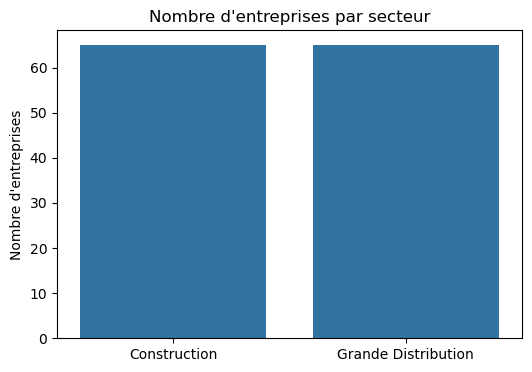

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Secteur')
plt.title("Nombre d'entreprises par secteur")
plt.xlabel("")
plt.ylabel("Nombre d'entreprises")
plt.show()


Ce graphique montre que les deux secteurs (Construction et Grande Distribution) comptent un nombre équivalent d’entreprises. Cela permet une comparaison équilibrée pour l’analyse de risque.


### 6.2 Distribution des probabilités de défaut (PD)

L’analyse de la distribution des probabilités de défaut permet d’évaluer le niveau global de risque
du portefeuille et d’identifier la présence éventuelle de poches de risque élevées.


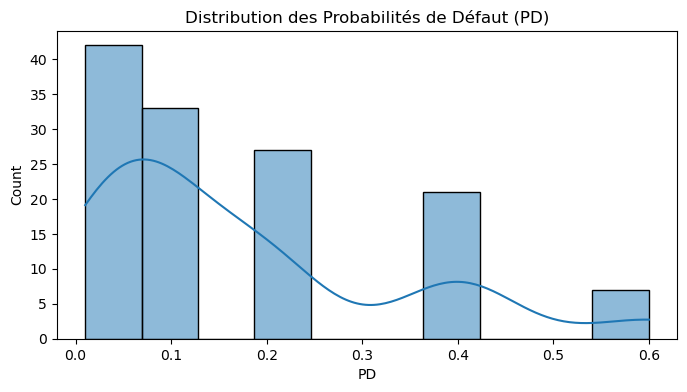

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='PD', bins=10, kde=True)
plt.title("Distribution des Probabilités de Défaut (PD)")
plt.show()


La majorité des entreprises présente une probabilité de défaut faible, ce qui suggère un portefeuille globalement sain, bien qu’une minorité ait un PD élevé.


### 6.3 Analyse des encours par secteur

Cette visualisation compare la dispersion et les niveaux d’encours entre les secteurs.
Elle permet d’identifier d’éventuelles concentrations de risque liées à la taille des expositions.


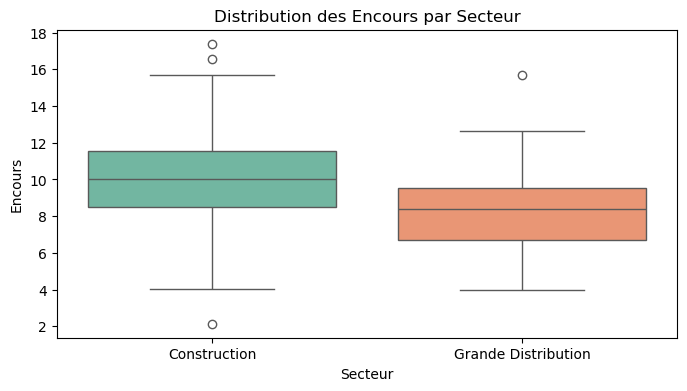

In [15]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df,
    x='Secteur',
    y='Encours',
    hue='Secteur',
    palette='Set2',
    legend=False
)
plt.title("Distribution des Encours par Secteur")
plt.show()



Les encours sont plus dispersés dans le secteur de la Grande Distribution que dans la Construction, ce qui pourrait refléter une variabilité de taille ou de chiffre d'affaires parmi les entreprises.


### 6.4 Relation entre encours et probabilité de défaut

Ce graphique explore la relation entre le montant des encours et le niveau de risque de crédit.
Il permet de vérifier si les expositions les plus importantes correspondent à des risques plus élevés.


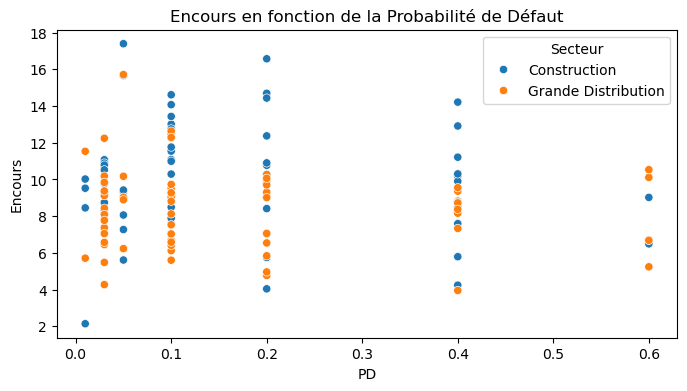

In [16]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='PD', y='Encours', hue='Secteur')
plt.title("Encours en fonction de la Probabilité de Défaut")
plt.show()


Il n’y a pas de lien clair entre l’encours et la probabilité de défaut. Toutefois, on remarque que les entreprises à haut encours ne présentent pas nécessairement un risque plus élevé.


### 6.5 Synthèse de l’analyse exploratoire

L’analyse exploratoire met en évidence un portefeuille globalement équilibré entre les secteurs,
composé majoritairement d’entreprises à faible probabilité de défaut.
Aucune relation linéaire forte n’apparaît entre les encours et le risque de défaut,
ce qui justifie le recours à des indicateurs agrégés et à des scénarios de stress
pour approfondir l’évaluation du risque global.


---



## <span style="color:#1f4fd8;">7. Calcul des indicateurs clés (PD, EL)</span>


### 7.1 Définition des paramètres de risque (PD, LGD)

Les indicateurs de risque utilisés dans cette analyse reposent sur les standards bancaires classiques :

- **PD (Probability of Default)** : probabilité annuelle de défaut d’une entreprise,
- **LGD (Loss Given Default)** : proportion de la perte en cas de défaut,
- **Encours** : exposition financière portée par la banque.

La LGD est ici définie à partir de la notation de crédit, selon une grille simplifiée inspirée des pratiques bancaires.


In [17]:
# Définition de la LGD par notation (Loss Given Default)
lgd_map = {
    'AAA': 0.20,
    'AA':  0.25,
    'A':   0.30,
    'BBB': 0.40,
    'BB':  0.50,
    'B':   0.60,
    'CCC': 0.70
}


In [18]:
# Création de la colonne LGD
df['LGD'] = df['Notation'].map(lgd_map)

# Vérification
df[['Notation', 'LGD']].head()


,Notation,LGD
0,BBB,0.40
1,AA,0.25
2,BBB,0.40
3,BBB,0.40
4,A,0.30


In [19]:
df[['Notation', 'LGD']].head()


,Notation,LGD
0,BBB,0.40
1,AA,0.25
2,BBB,0.40
3,BBB,0.40
4,A,0.30


 Calcul de la Perte Attendue (Expected Loss)

### 7.2 Calcul de la Perte Attendue (Expected Loss)

La perte attendue (EL) mesure le risque moyen supporté par la banque sur chaque exposition.
Elle est calculée selon la formule standard :

EL = PD × LGD × Encours

Cet indicateur permet d’évaluer le coût du risque de crédit à l’échelle individuelle.


In [20]:

df['PerteAttendue'] = df['PD'] * df['LGD'] * df['Encours']


In [21]:
df[['NomEntreprise',
    'Secteur',
    'Encours',
    'Notation',
    'PD',
    'LGD',
    'PerteAttendue']].head()


,NomEntreprise,Secteur,Encours,Notation,PD,LGD,PerteAttendue
0,ConstructCo_1,Construction,14.07,BBB,0.10,0.40,0.56280
1,ConstructCo_2,Construction,9.78,AA,0.03,0.25,0.07335
2,ConstructCo_3,Construction,13.01,BBB,0.10,0.40,0.52040
3,ConstructCo_4,Construction,11.08,BBB,0.10,0.40,0.44320
4,ConstructCo_5,Construction,8.06,A,0.05,0.30,0.12090


In [22]:
# 🔒 Sécurisation du DataFrame pour les graphiques EL

# Vérification des colonnes
print(df.columns)

# Recalcul explicite (sécurité)
df['PerteAttendue'] = df['PD'] * df['LGD'] * df['Encours']

# Forcer numérique
df['PerteAttendue'] = pd.to_numeric(df['PerteAttendue'], errors='coerce')

# Nettoyage final
df = df.dropna(subset=['Secteur', 'PerteAttendue'])

# Check final
print(df[['Secteur', 'PerteAttendue']].head())


Index(['NomEntreprise', 'Secteur', 'ChiffreAffaires', 'Encours', 'Notation',
       'PD', 'LGD', 'PerteAttendue'],
      dtype='object')
        Secteur  PerteAttendue
0  Construction        0.56280
1  Construction        0.07335
2  Construction        0.52040
3  Construction        0.44320
4  Construction        0.12090


### 7.3 Analyse de la Perte Attendue par secteur

Cette analyse compare la distribution des pertes attendues entre les secteurs
afin d’identifier d’éventuelles concentrations de risque sectoriel.


In [23]:
# Préparation des données pour l'analyse sectorielle

# Vérification que df existe
df.head()

# Nettoyage des noms de colonnes
df.columns = df.columns.str.strip()

# Forcer PerteAttendue en numérique
df["PerteAttendue"] = pd.to_numeric(df["PerteAttendue"], errors="coerce")

# Suppression des lignes invalides
df = df.dropna(subset=["Secteur", "PerteAttendue"])

# Vérification rapide
df[["Secteur", "PerteAttendue"]].head()


,Secteur,PerteAttendue
0,Construction,0.56280
1,Construction,0.07335
2,Construction,0.52040
3,Construction,0.44320
4,Construction,0.12090


### 7.4 Analyse de la Perte Attendue par notation

La perte attendue est analysée par classe de notation afin de vérifier
la cohérence entre niveau de risque de crédit et impact financier.
Les notations les plus faibles doivent logiquement concentrer les pertes les plus élevées.


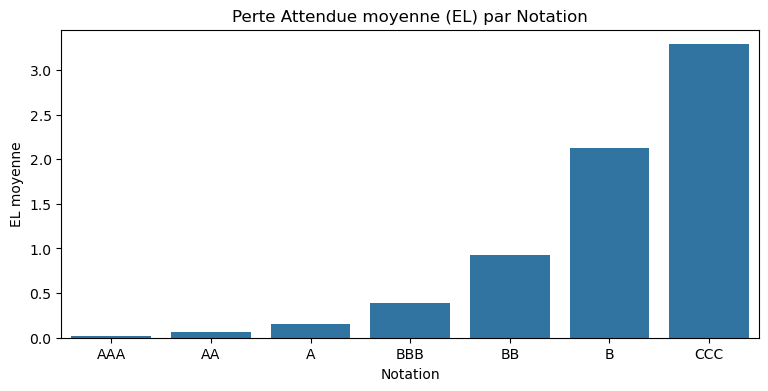

In [24]:
plt.figure(figsize=(9,4))
ordre = ['AAA','AA','A','BBB','BB','B','CCC']
sns.barplot(data=df, x='Notation', y='PerteAttendue', order=ordre, errorbar=None)
plt.title("Perte Attendue moyenne (EL) par Notation")
plt.ylabel("EL moyenne")
plt.xlabel("Notation")
plt.show()


Affichage d'un extrait avec les nouvelles colonnes.
La perte attendue augmente fortement à mesure que la notation se dégrade, 
confirmant la cohérence entre qualité de crédit, probabilité de défaut 
et impact financier attendu.


In [25]:

df[['NomEntreprise', 'Secteur', 'Encours', 'Notation', 'PD', 'LGD', 'PerteAttendue']].head()



,NomEntreprise,Secteur,Encours,Notation,PD,LGD,PerteAttendue
0,ConstructCo_1,Construction,14.07,BBB,0.10,0.40,0.56280
1,ConstructCo_2,Construction,9.78,AA,0.03,0.25,0.07335
2,ConstructCo_3,Construction,13.01,BBB,0.10,0.40,0.52040
3,ConstructCo_4,Construction,11.08,BBB,0.10,0.40,0.44320
4,ConstructCo_5,Construction,8.06,A,0.05,0.30,0.12090


In [26]:
df.head(10)


,NomEntreprise,Secteur,ChiffreAffaires,Encours,Notation,PD,LGD,PerteAttendue
0,ConstructCo_1,Construction,54.97,14.07,BBB,0.10,0.40,0.56280
1,ConstructCo_2,Construction,48.62,9.78,AA,0.03,0.25,0.07335
2,ConstructCo_3,Construction,56.48,13.01,BBB,0.10,0.40,0.52040
3,ConstructCo_4,Construction,65.23,11.08,BBB,0.10,0.40,0.44320
4,ConstructCo_5,Construction,47.66,8.06,A,0.05,0.30,0.12090
5,ConstructCo_6,Construction,47.66,11.08,BBB,0.10,0.40,0.44320
6,ConstructCo_7,Construction,65.79,14.61,BBB,0.10,0.40,0.58440
7,ConstructCo_8,Construction,57.67,9.89,BB,0.20,0.50,0.98900
8,ConstructCo_9,Construction,45.31,14.69,BB,0.20,0.50,1.46900
9,ConstructCo_10,Construction,55.43,2.14,AAA,0.01,0.20,0.00428


In [27]:
df['Notation'].value_counts()


Notation
BBB    33
BB     27
AA     23
B      21
A      13
CCC     7
AAA     6
Name: count, dtype: int64

In [28]:
# Calcul de la Perte Attendue
df['PerteAttendue'] = df['PD'] * df['LGD'] * df['Encours']

# Affichage d’un extrait pour vérifier
df[['NomEntreprise', 'Secteur', 'Encours', 'PD', 'PerteAttendue']].head(10)


,NomEntreprise,Secteur,Encours,PD,PerteAttendue
0,ConstructCo_1,Construction,14.07,0.10,0.56280
1,ConstructCo_2,Construction,9.78,0.03,0.07335
2,ConstructCo_3,Construction,13.01,0.10,0.52040
3,ConstructCo_4,Construction,11.08,0.10,0.44320
4,ConstructCo_5,Construction,8.06,0.05,0.12090
5,ConstructCo_6,Construction,11.08,0.10,0.44320
6,ConstructCo_7,Construction,14.61,0.10,0.58440
7,ConstructCo_8,Construction,9.89,0.20,0.98900
8,ConstructCo_9,Construction,14.69,0.20,1.46900
9,ConstructCo_10,Construction,2.14,0.01,0.00428


### 7.5 Agrégation des pertes à l’échelle du portefeuille

Les pertes attendues sont ensuite agrégées par secteur afin d’obtenir
une vision globale du risque porté par la banque sur l’ensemble du portefeuille.


               Secteur  PerteAttendue
0         Construction       57.91301
1  Grande Distribution       51.43623


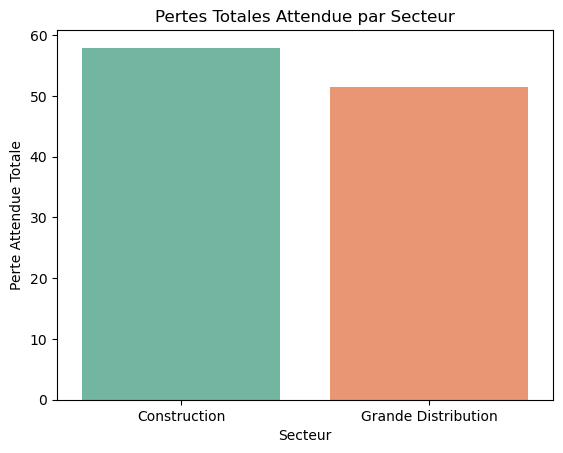

In [29]:
# Calcul de la perte totale par secteur
pertes_par_secteur = df.groupby('Secteur')['PerteAttendue'].sum().reset_index()

# Affichage
print(pertes_par_secteur)


sns.barplot(
    data=pertes_par_secteur,
    x='Secteur',
    y='PerteAttendue',
    hue='Secteur',
    palette='Set2',
    legend=False
)
plt.title("Pertes Totales Attendue par Secteur")
plt.ylabel("Perte Attendue Totale")
plt.xlabel("Secteur")
plt.show()


In [30]:
df_stress = df.copy()


In [31]:
# Application du stress : augmentation des PD
df_stress.loc[df_stress['Secteur'] == 'Construction', 'PD'] *= 1.3
df_stress.loc[df_stress['Secteur'] == 'Grande Distribution', 'PD'] *= 1.1


In [32]:
# Recalcul de la LGD dans le dataframe stressé
df_stress['LGD'] = df_stress['Notation'].map(lgd_map)

# Recalcul de la Perte Attendue après stress
df_stress['PerteAttendue'] = df_stress['PD'] * df_stress['LGD'] * df_stress['Encours']




In [33]:
# Pertes totales avant stress
pertes_avant = df.groupby('Secteur')['PerteAttendue'].sum().reset_index()
pertes_avant.rename(columns={'PerteAttendue': 'PerteAvantStress'}, inplace=True)

# Pertes totales après stress
pertes_apres = df_stress.groupby('Secteur')['PerteAttendue'].sum().reset_index()
pertes_apres.rename(columns={'PerteAttendue': 'PerteApresStress'}, inplace=True)

# Fusion des deux pour comparaison
comparaison = pd.merge(pertes_avant, pertes_apres, on='Secteur')
comparaison['Variation (%)'] = ((comparaison['PerteApresStress'] - comparaison['PerteAvantStress']) / comparaison['PerteAvantStress']) * 100

comparaison


,Secteur,PerteAvantStress,PerteApresStress,Variation (%)
0,Construction,57.91301,75.286913,30.0
1,Grande Distribution,51.43623,56.579853,10.0


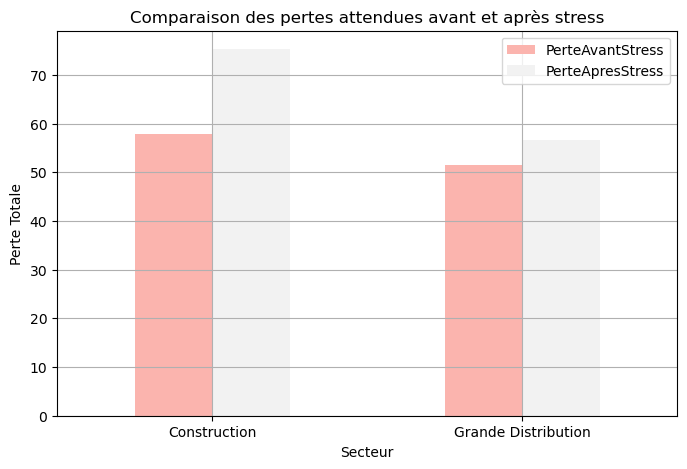

In [34]:
comparaison.plot(
    x='Secteur', 
    y=['PerteAvantStress', 'PerteApresStress'], 
    kind='bar', 
    figsize=(8,5), 
    colormap='Pastel1'
)
plt.title('Comparaison des pertes attendues avant et après stress')
plt.ylabel('Perte Totale')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


Le stress macroéconomique impacte significativement le secteur cyclique de la Construction, confirmant sa sensibilité accrue aux chocs, tandis que le secteur défensif de la Grande Distribution reste relativement résilient.

In [35]:
# Mapping PD par notation (référence bancaire simplifiée)
# Nouvelle calibration PD utilisée pour la simulation élargie (baseline / stress)
notation_pd = {
    'AAA': 0.005,
    'AA':  0.01,
    'A':   0.03,
    'BBB': 0.06,
    'BB':  0.10,
    'B':   0.20,
    'CCC': 0.60
}


# Mapping LGD par notation
lgd_map = {
    'AAA': 0.20,
    'AA':  0.25,
    'A':   0.30,
    'BBB': 0.40,
    'BB':  0.50,
    'B':   0.60,
    'CCC': 0.70
}


### 7.6 Synthèse des indicateurs de risque

L’analyse met en évidence :

- une perte attendue globalement maîtrisée,
- une concentration du risque plus marquée sur certaines notations dégradées,
- une exposition sectorielle différenciée mais cohérente avec les hypothèses initiales.

Ces résultats constituent une base de référence pour l’analyse en scénario de stress.


---



## <span style="color:#1f4fd8;"> 8. Extension du portefeuille – Simulation élargie</span>


### 8.1 Objectif de la simulation élargie

L’objectif de cette section est d’étendre le portefeuille initial à un volume plus réaliste
d’expositions afin d’analyser le comportement du risque de crédit à l’échelle d’un
portefeuille bancaire.

Cette simulation permet d’étudier la répartition sectorielle, la structure des notations
de crédit et la perte attendue sur un portefeuille élargi.


### 8.2 Paramétrage général de la simulation

In [36]:
np.random.seed(42)  # reproductibilité

n_total = 130

### 8.3 Simulation de la répartition sectorielle

La répartition sectorielle du portefeuille est simulée selon une hypothèse réaliste,
avec une exposition légèrement plus importante au secteur de la construction.


In [37]:
# Répartition sectorielle (exemple réaliste)
secteurs = np.random.choice(
    ['Construction', 'Grande Distribution'],
    size=n_total,
    p=[0.55, 0.45]
)

### 8.4 Simulation des notations de crédit

Les notations de crédit sont simulées en fonction du secteur d’activité, en intégrant
des probabilités différenciées reflétant le profil de risque propre à chaque secteur.


In [38]:
# Notations possibles
notations = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

# Probabilités de notation par secteur (guidées métier)
proba_notation_construction = [0.02, 0.05, 0.15, 0.28, 0.25, 0.15, 0.10]
proba_notation_distribution = [0.05, 0.15, 0.30, 0.30, 0.12, 0.06, 0.02]

notations_simulees = []
for s in secteurs:
    if s == 'Construction':
        notations_simulees.append(
            np.random.choice(notations, p=proba_notation_construction)
        )
    else:
        notations_simulees.append(
            np.random.choice(notations, p=proba_notation_distribution)
        )

### 8.5 Simulation des encours et du chiffre d’affaires

Les encours sont simulés selon une distribution normale tronquée afin de garantir des
valeurs positives. Le chiffre d’affaires est généré de manière cohérente avec le niveau
d’encours.


In [39]:
# Encours simulés (en millions, positifs)
encours = np.round(
    np.abs(np.random.normal(loc=10, scale=4, size=n_total)),
    2
)

# Chiffre d'affaires simulé (optionnel, cohérent avec l'encours)
chiffre_affaires = np.round(encours * np.random.uniform(1.5, 3.0, size=n_total), 2)


### 8.6 Construction du DataFrame simulé

Les différentes variables simulées sont regroupées au sein d’un DataFrame unique
représentant le portefeuille élargi.


In [40]:
# DataFrame simulé
df_simule = pd.DataFrame({
    'Secteur': secteurs,
    'Notation': notations_simulees,
    'Encours': encours,
    'ChiffreAffaires': chiffre_affaires
})

df_simule.head()


,Secteur,Notation,Encours,ChiffreAffaires
0,Construction,BBB,10.23,27.49
1,Grande Distribution,A,5.43,14.58
2,Grande Distribution,AA,11.43,18.71
3,Grande Distribution,A,12.24,27.44
4,Construction,CCC,14.33,22.73


### 8.7 Intégration des paramètres de risque (PD, LGD)

Les probabilités de défaut (PD) et les taux de perte en cas de défaut (LGD) sont
attribués à chaque exposition en fonction de la notation de crédit.


In [41]:
# Mapping PD par notation (déjà utilisé plus haut)
df_simule['PD'] = df_simule['Notation'].map(notation_pd)

# Mapping LGD par notation (déjà utilisé plus haut)
df_simule['LGD'] = df_simule['Notation'].map(lgd_map)


### 8.8 Calcul de la Perte Attendue (EL)

La perte attendue est calculée selon la formule standard :
EL = PD × LGD × Encours.


In [42]:
# Calcul de la Perte Attendue
df_simule['PerteAttendue'] = df_simule['PD'] * df_simule['LGD'] * df_simule['Encours']

df_simule.head()


,Secteur,Notation,Encours,ChiffreAffaires,PD,LGD,PerteAttendue
0,Construction,BBB,10.23,27.49,0.06,0.40,0.245520
1,Grande Distribution,A,5.43,14.58,0.03,0.30,0.048870
2,Grande Distribution,AA,11.43,18.71,0.01,0.25,0.028575
3,Grande Distribution,A,12.24,27.44,0.03,0.30,0.110160
4,Construction,CCC,14.33,22.73,0.60,0.70,6.018600


### 8.9 Analyse descriptive du portefeuille simulé

Cette section permet de vérifier la cohérence globale du portefeuille simulé
(répartition sectorielle, encours totaux et structure des notations).


In [43]:
df_simule.shape


(130, 7)

In [44]:
df_simule.groupby('Secteur')['Encours'].sum()


Secteur
Construction           811.02
Grande Distribution    545.39
Name: Encours, dtype: float64

In [45]:
df_simule['Notation'].value_counts(normalize=True).round(2)


Notation
BB     0.25
BBB    0.25
A      0.22
B      0.11
AA     0.07
CCC    0.06
AAA    0.05
Name: proportion, dtype: float64

---


## <span style="color:#1f4fd8;">  9. Scénario de stress sévère – Choc sur les PD</span>


### 9.1 Construction du scénario de stress



In [46]:
# Copie du portefeuille simulé pour le stress
df_stress = df_simule.copy()

# Application d’un stress sévère sur les PD
# Objectif : faire passer la PD moyenne Construction vers 10–15%

df_stress.loc[df_stress['Secteur'] == 'Construction', 'PD'] *= 2.5
df_stress.loc[df_stress['Secteur'] == 'Grande Distribution', 'PD'] *= 1.3

# Cap de sécurité (PD max = 100%)
df_stress['PD'] = df_stress['PD'].clip(upper=1.0)

# Recalcul de la Perte Attendue après stress
df_stress['PerteAttendue'] = (
    df_stress['PD'] * df_stress['LGD'] * df_stress['Encours']
)

df_stress.head()


,Secteur,Notation,Encours,ChiffreAffaires,PD,LGD,PerteAttendue
0,Construction,BBB,10.23,27.49,0.150,0.40,0.613800
1,Grande Distribution,A,5.43,14.58,0.039,0.30,0.063531
2,Grande Distribution,AA,11.43,18.71,0.013,0.25,0.037147
3,Grande Distribution,A,12.24,27.44,0.039,0.30,0.143208
4,Construction,CCC,14.33,22.73,1.000,0.70,10.031000


###  9.2 Analyse de la sévérité du stress


### Analyse de la sévérité du stress

Le scénario de stress appliqué vise à simuler un choc macroéconomique
sévère affectant principalement le secteur de la Construction.

Dans ce scénario, les probabilités de défaut (PD) du secteur Construction
sont volontairement amplifiées afin d’atteindre une PD moyenne comprise
entre 10 % et 15 %, correspondant à une situation de crise sectorielle
majeure.

Cette hypothèse permet d’évaluer la robustesse du portefeuille face à un
choc crédible mais extrême, conformément aux pratiques de stress testing
utilisées en gestion du risque bancaire.


### 9.3 Concentration de l’encours par secteur (post-stress)


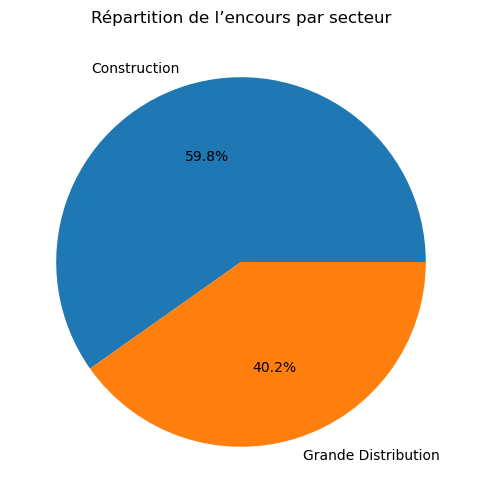

In [47]:
# Analyse de la concentration de l'encours par secteur
encours_secteur = df_stress.groupby('Secteur')['Encours'].sum()

encours_secteur.plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6,6),
    title='Répartition de l’encours par secteur'
)
plt.ylabel('')
plt.show()


### 9.4 Mise en forme finale des résultats


In [48]:
# Arrondi des colonnes financières pour la lisibilité
cols_to_round = ['Encours', 'ChiffreAffaires', 'PD', 'LGD', 'PerteAttendue']

df_simule[cols_to_round] = df_simule[cols_to_round].round(2)
df_stress[cols_to_round] = df_stress[cols_to_round].round(2)

df_simule.head()


,Secteur,Notation,Encours,ChiffreAffaires,PD,LGD,PerteAttendue
0,Construction,BBB,10.23,27.49,0.06,0.40,0.25
1,Grande Distribution,A,5.43,14.58,0.03,0.30,0.05
2,Grande Distribution,AA,11.43,18.71,0.01,0.25,0.03
3,Grande Distribution,A,12.24,27.44,0.03,0.30,0.11
4,Construction,CCC,14.33,22.73,0.60,0.70,6.02


### 9.5 Mesure de l’impact du stress – Delta de perte attendue

Afin de quantifier l’impact du scénario de stress sur le portefeuille, un indicateur de variation de la perte attendue (Delta EL) est calculé.  
Cet indicateur correspond à la différence entre la perte attendue après stress et la perte attendue en situation normale.

Le Delta de perte constitue un indicateur central en gestion du risque bancaire, car il permet d’évaluer l’augmentation du risque induite par un choc macroéconomique et d’anticiper les besoins en fonds propres.


In [49]:
# Calcul de la perte totale avant stress
el_base = df_simule.groupby('Secteur')['PerteAttendue'].sum().reset_index()
el_base.rename(columns={'PerteAttendue': 'EL_Base'}, inplace=True)

# Calcul de la perte totale après stress
el_stress = df_stress.groupby('Secteur')['PerteAttendue'].sum().reset_index()
el_stress.rename(columns={'PerteAttendue': 'EL_Stress'}, inplace=True)

# Calcul du Delta de perte
el_comparison = el_base.merge(el_stress, on='Secteur')
el_comparison['EL_Delta'] = el_comparison['EL_Stress'] - el_comparison['EL_Base']

el_comparison


,Secteur,EL_Base,EL_Stress,EL_Delta
0,Construction,69.76,142.83,73.07
1,Grande Distribution,13.49,17.51,4.02


###  9.6 Lecture des résultats du stress test


Le scénario de stress met en évidence une augmentation significative de la perte attendue sur le secteur de la Construction, traduisant une forte sensibilité à une dégradation macroéconomique sévère.

La Grande Distribution, bien que touchée par le stress, conserve un profil de risque plus modéré, reflétant une meilleure diversification et une résilience relative face au choc appliqué.

Le stress test met en évidence une forte asymétrie de l’impact du choc macroéconomique : le secteur de la Construction concentre l’essentiel de l’augmentation de la perte attendue, confirmant son caractère fortement cyclique malgré une part d’encours comparable à celle de la Grande Distribution. Ce résultat souligne le rôle déterminant de la concentration sectorielle dans le risque global du portefeuille et l’intérêt des scénarios de stress sévères pour anticiper les besoins en fonds propres et orienter les décisions de pilotage du risque de crédit.

### 9.7 Conclusion chiffrée : EL totale avant / après stress + secteur le plus impacté

In [50]:
el_total_base = df_simule["PerteAttendue"].sum()
el_total_stress = df_stress["PerteAttendue"].sum()
delta_total = el_total_stress - el_total_base
delta_pct = (delta_total / el_total_base) * 100 if el_total_base != 0 else float("nan")

# Secteur le plus impacté (en delta)
el_base_sec = df_simule.groupby("Secteur")["PerteAttendue"].sum()
el_stress_sec = df_stress.groupby("Secteur")["PerteAttendue"].sum()
delta_sec = (el_stress_sec - el_base_sec).sort_values(ascending=False)

secteur_max = delta_sec.index[0]
delta_max = delta_sec.iloc[0]

print("=== Conclusion chiffrée ===")
print(f"EL totale avant stress  : {el_total_base:.2f}")
print(f"EL totale après stress  : {el_total_stress:.2f}")
print(f"Delta total (EL)        : {delta_total:.2f} ({delta_pct:.1f}%)")
print(f"Secteur le plus impacté : {secteur_max} (Δ = {delta_max:.2f})")


=== Conclusion chiffrée ===
EL totale avant stress  : 83.25
EL totale après stress  : 160.34
Delta total (EL)        : 77.09 (92.6%)
Secteur le plus impacté : Construction (Δ = 73.07)


In [51]:
from IPython.display import display, Markdown

display(Markdown(f"""
### Conclusion chiffrée finale

La perte attendue totale du portefeuille passe de **{el_total_base:.2f}**
avant stress à **{el_total_stress:.2f}** après stress, soit une augmentation
absolue de **{delta_total:.2f}**, correspondant à une hausse de
**{delta_pct:.1f} %**.

Le secteur **{secteur_max}** concentre l’essentiel de cette dégradation,
avec un delta de perte attendue de **{delta_max:.2f}**, confirmant sa forte
sensibilité aux chocs macroéconomiques sévères.

Cette analyse met en évidence le rôle déterminant de la concentration
sectorielle dans le risque global du portefeuille et illustre l’intérêt
des stress tests dans l’anticipation des besoins en fonds propres et le
pilotage du risque de crédit.
"""))



### Conclusion chiffrée finale

La perte attendue totale du portefeuille passe de **83.25**
avant stress à **160.34** après stress, soit une augmentation
absolue de **77.09**, correspondant à une hausse de
**92.6 %**.

Le secteur **Construction** concentre l’essentiel de cette dégradation,
avec un delta de perte attendue de **73.07**, confirmant sa forte
sensibilité aux chocs macroéconomiques sévères.

Cette analyse met en évidence le rôle déterminant de la concentration
sectorielle dans le risque global du portefeuille et illustre l’intérêt
des stress tests dans l’anticipation des besoins en fonds propres et le
pilotage du risque de crédit.
